<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Multilable%20Emotion%20Classification/multilabel_emotions_classification_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Dataset

In [37]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv

--2025-08-08 18:12:33--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 172.217.194.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv.2’

goemotions_1.csv.2  100%[===================>]  13.52M  7.38MB/s    in 1.8s    

2025-08-08 18:12:35 (7.38 MB/s) - ‘data/full_dataset/goemotions_1.csv.2’ saved [14174600/14174600]



# Import Libs & Setup Enviorment

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Input, Dense, Embedding,
                                     LSTM, Dropout, Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import (f1_score, precision_score, recall_score,
                            classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

In [39]:
# Download NLTK stopwords
nltk.download('stopwords')
emotional_words = {'happy', 'sad', 'angry', 'excited', 'scared', 'love', 'hate', 'joy', 'fear'}
stop_words = set(stopwords.words('english')) - emotional_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# Configuration
MAX_SEQUENCE_LENGTH=30
EMBEDDING_DIM=100
MAX_VOCAB_SIZE=20_000
VALIDATION_SPLIT=0.2
BATCH_SIZE=256
EPOCHS=50
L2_REG=0.001
DROPOUT_RATE=0.4

In [41]:
# Initialize TPU or GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
    RECURRENT_DROPOUT = 0.0  # Disable recurrent_dropout for TPU
except ValueError:
    strategy = tf.distribute.get_strategy()  # Fallback to GPU/CPU
    print("Running on GPU/CPU")
    RECURRENT_DROPOUT = DROPOUT_RATE  # Enable recurrent_dropout for GPU/CPU

Running on GPU/CPU


# Text Cleaning Function

In [42]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    text = re.sub(r"\s+", " ", text).strip()
    return text if text else "DUMMY_VALUE"

# Load And Analyze Dataset

In [76]:
df = pd.read_csv("data/full_dataset/goemotions_1.csv")
df.head(5)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


> Separating Labels

In [77]:
# Filter unclear texts and short texts
df = df[df['example_very_unclear'] == False]
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3]

# Define label columns
label_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

# Keep labels with sufficient samples
label_columns = [col for col in label_columns if df[col].sum() >= 1000]
labels = df[label_columns].values
num_classes = len(label_columns)
print(f"Number of label classes: {num_classes}")

Number of label classes: 22


> Analyzing labels

In [68]:
# Analyze label distribution
label_sums = df[label_columns].sum()
print(label_sums)

admiration         5647
amusement          3081
anger              2589
annoyance          4443
approval           5928
caring             1988
confusion          2471
curiosity          3267
desire             1248
disappointment     2771
disapproval        3774
disgust            1704
excitement         1900
fear               1048
gratitude          3863
joy                2607
love               2745
optimism           2887
realization        2867
sadness            2193
surprise           1806
neutral           18423
dtype: int64


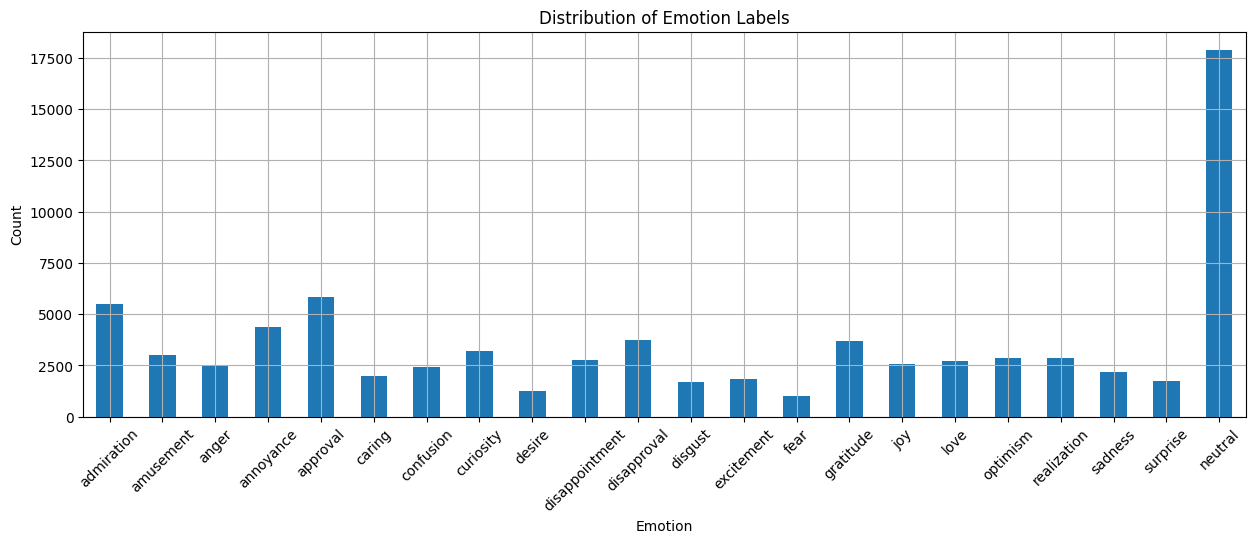

In [79]:
label_sums = df[label_columns].sum()
plt.figure(figsize=(15, 5))
label_sums.plot(kind='bar')
plt.title("Distribution of Emotion Labels")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

> `text` Cleaning

In [80]:
# Cleaning & Separating sentences
df["text"] = df["text"].apply(clean_text)
sentences = df["text"].values

# Sequences Statistics

In [81]:
# Min/Max length of sentences
print(f"Max sequence length: {max(len(s.split()) for s in sentences)}")
print(f"Max sequence length: {min(len(s.split()) for s in sentences)}")

# median length of sentences
s = sorted(len(s.split()) for s in sentences)
print(f"Median sequence length: {s[len(s) // 2]}")

Max sequence length: 28
Max sequence length: 1
Median sequence length: 7


# Tokenization & Padding

In [82]:
# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# Get word2idx
word2idx = tokenizer.word_index
print(f"Found {len(word2idx)} unique tokens.")

Found 27119 unique tokens.


In [83]:
# Padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,
                     truncating='post', padding='post')
print(f"Shape of data tensor: {data.shape}")

Shape of data tensor: (67407, 30)


# Spliting Train/Test Set

In [84]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Check shapes
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of test data: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of training data: (53925, 30)
Shape of test data: (13482, 30)
Shape of y_train: (53925, 22)
Shape of y_test: (13482, 22)


# Define Model

In [85]:
with strategy.scope():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), name="input_layer")
    embedding_layer = Embedding(
                                input_dim=min(MAX_VOCAB_SIZE, len(word2idx)+1),
                                output_dim=EMBEDDING_DIM,
                                trainable=True,
                                name="embedding_layer")(input_layer)
    lstm1 = Bidirectional(LSTM(
                                units=128, return_sequences=True,
                                recurrent_dropout=RECURRENT_DROPOUT,
                                kernel_regularizer=l2(L2_REG), name="lstm1"))(embedding_layer)
    dropout1 = Dropout(DROPOUT_RATE, name="dropout1")(lstm1)
    lstm2 = LSTM(
                    units=64, return_sequences=False,
                    recurrent_dropout=RECURRENT_DROPOUT,
                    kernel_regularizer=l2(L2_REG), name="lstm2")(dropout1)
    dropout2 = Dropout(DROPOUT_RATE, name="dropout2")(lstm2)
    output_layer = Dense(units=num_classes,
                         activation="sigmoid",
                         kernel_regularizer=l2(L2_REG),
                         name="output_layer")(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)

# Compite Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 30, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 30, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,318,102 (8.84 MB)

 Trainable params: 2,318,102 (8.84 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks

In [87]:
# Define Callbacks
checkpoint = ModelCheckpoint(
    filepath="multi_label_emotions_best.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[checkpoint, early_stopping, lr_scheduler],
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.1557 - loss: 0.6243
Epoch 1: val_loss improved from inf to 0.22167, saving model to multi_label_emotions_best.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 271ms/step - accuracy: 0.1559 - loss: 0.6229 - val_accuracy: 0.2657 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.2444 - loss: 0.2260
Epoch 2: val_loss improved from 0.22167 to 0.20633, saving model to multi_label_emotions_best.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - accuracy: 0.2444 - loss: 0.2260 - val_accuracy: 0.2657 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.2574 - loss: 0.2104
Epoch 3: val_loss improved from 0.20633 to 0.19949, saving model to multi_label_emotions_best.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 252ms/step - accuracy: 0.2574 - loss: 0.2104 - val_accuracy: 0.2657 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 4/

# Check Model Accuracy

In [ ]:
# Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Evaluate Model
print("\nEvaluating on test set...")
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Threshold at 0.5
f1 = f1_score(y_test, y_pred_binary, average='weighted')
precision = precision_score(y_test, y_pred_binary, average='weighted')
recall = recall_score(y_test, y_pred_binary, average='weighted')
print(f"Test F1-Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, target_names=label_columns))

In [ ]:
# Confusion Matrix for each label
print("\nConfusion Matrices:")
for i, label in enumerate(label_columns):
    cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Load the Best Model and Test

In [ ]:
# Load Best Model for Final Evaluation
print("\nLoading best model for final evaluation...")
best_model = tf.keras.models.load_model("multi_label_emotions_best.h5")
y_pred_best = best_model.predict(X_test)
y_pred_best_binary = (y_pred_best > 0.5).astype(int)
best_f1 = f1_score(y_test, y_pred_best_binary, average='weighted')
print(f"Best Model Test F1-Score: {best_f1:.4f}")

In [ ]:
# Test with a new comment
print("\nTesting with a new comment...")
text = "This is so exciting and a bit scary!"
cleaned_text = clean_text(text)
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
prediction = best_model.predict(padded)
predicted_labels = [label_columns[i] for i in range(len(label_columns)) if prediction[0][i] > 0.5]
print(f"Comment: {text}")
print(f"Predicted emotions: {predicted_labels}")